In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np
from copy import deepcopy

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are used:
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. CNN Architecture

This Convolutional Neural Network follows the architecture of LeNet. However, instead of using Tanh activation function and average pooling, **ReLU activation function** and **max pooling** is used. Also, **dropout layers** and **batch normalization layers** have been added.

**Architecture:** Input &#8594; CONV1 &#8594; NORM1 &#8594; ReLU &#8594; POOL2 &#8594; CONV3 &#8594; NORM2 &#8594; ReLU &#8594; POOL4 &#8594; CONV5 &#8594; FC6 &#8594; Softmax

Convolutional layers:
* **CONV1**: 6 filters and kernel size of 5 x 5
* **CONV3**: 16 filters and kernel size of 5 x 5
* **CONV5**:120 filters and kernel size of 5 x 5

Pooling Layers:
* **POOL2, POOL4**: max pooling layers with receptive field of 2 x 2.

Activations:
* ReLU activation function **(hidden layer)**
* Softmax activation function **(output layer)**

Regularization:
* Weight decay (L2 regularization)
* Dropout layers

Normalization:
* Batch normalization

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
class CNN(nn.Module):
    """ Convolutional Neural Network for multiclass classification.
    
    This CNN follows the architecture of LeNet. However, instead of using 
    Tanh activation function and average pooling, ReLU activation function 
    and max pooling is used. Also, dropout layers and batch normalization layers have been added.
    
    The CNN architecture is as follows:
    Input → CONV1 → NORM1 → ReLU → POOL2 → CONV3 → NORM2 → ReLU → POOL4 → CONV5 → FC6 → Softmax
    
    The convolutional layers are configured as follows:
    * CONV1: 6 filters and kernel size of 5 x 5
    * CONV3: 16 filters and kernel size of 5 x 5
    * CONV5: 120 filters and kernel size of 5 x 5
    
    The pooling layers are configured as follwos:
    * POOL2, POOL4: max pooling layers with receptive field of 2 x 2.
    
    The hyperparameters of the CNN are:
    * probability of dropout layer.
    
    Arguments:
        in_channels:
            size of input, as an integer.
        output_size:
            size of output (number of labels), as an integer
        p:
            dropout probability, as a float.
    """
    
    def __init__(self, in_channels, output_size, p):
        """ Initialize Convolutional Neural Network.
        
        Args:
            in_channels:
                size of input, as an integer.
            output_size:
                size of output (number of labels), as an integer.
            p:
                dropout probability, as a float.
        """
        super(CNN, self).__init__()
        
        self.in_channels = in_channels
        self.output_size = output_size
        self.p = p
        
        # activation function
        self.activation = nn.ReLU()
        
        # convolutional layer: CONV1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        # convolutional layer: CONV3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        # max pooling layer 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # dropout layer
        self.dropout = nn.Dropout(p)
        
        # batch normalization layer: NORM1
        self.norm1 = nn.BatchNorm2d(6)
        # batch normalization layer: NORM2
        self.norm2 = nn.BatchNorm2d(16)
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_size)
        
    def forward(self, x):
        # Input --> CONV1 --> NORM --> ReLU --> POOL2
        pre = self.conv1(x)
        normalized = self.norm1(pre)
        post = self.activation(normalized)
        x = self.pool(post)
        
        # CONV3 → NORM → ReLU → POOL4
        pre = self.conv2(x)
        normalized = self.norm2(pre)
        post = self.activation(normalized)
        x = self.pool(post)
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        
        # CONV5
        logits = self.activation(self.fc1(x))
        logits = self.dropout(logits)
        
        # FC6
        logits = self.activation(self.fc2(logits))
        logits = self.dropout(logits)
        
        # outpout
        logits = self.fc3(logits)
        
        return logits

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| CNN                           | 1.01            | 65%                 |

Best trial **configuration** for CNN: p: 0.4, lr: 0.001, l2: 0.0001

In [6]:
def tune_helper(config, trainset, in_channels, num_labels, batch_size, epochs):
    """ Fit deep learning model and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        in_channels:
            number of input channels, as an integer.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    model = CNN(in_channels=in_channels,
                output_size=num_labels,
                p=config['p'])
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [7]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    in_channels = 3
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(tune.with_parameters(tune_helper, 
                                           trainset=trainset,
                                           in_channels=in_channels, 
                                           num_labels=num_labels,
                                           batch_size=batch_size,
                                           epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [8]:
# hyperparameter search space
config = {
    "p": tune.grid_search([0.4, 0.5, 0.6]),
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4]),
    }

In [9]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=30,
                    num_samples=1, 
                    cpus_per_trial=0,
                    gpus_per_trial=1)

Files already downloaded and verified
Files already downloaded and verified


2021-09-04 09:52:01,145	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-04 09:52:13,935	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-09-04 09:52:15,024	ERROR syncer.py:72 -- Log sync requires rsync to be installed.


== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (12 PENDING)
+-------------------------+----------+-------+--------+--------+-----+
| Trial name              | status   | loc   |     l2 |     lr |   p |
|-------------------------+----------+-------+--------+--------+-----|
| tune_helper_a2ba2_00000 | PENDING  |       | 0.001  | 0.001  | 0.4 |
| tune_helper_a2ba2_00001 | PENDING  |       | 0.0001 | 0.001  | 0.4 |
| tune_helper_a2ba2_00002 | PENDING  |       | 0.001  | 0.0001 | 0.4 |
| tune_helper_a2ba2_00003 | PENDING  |       | 0.0001 | 0.0001 | 0.4 |
| tune_helper_a2ba2_00004 | PENDING  |       | 0.001  | 0.001  | 0.5 |
| tune_helper_a2ba2_00005 | PENDING  |       | 0.0001 | 0.001  | 0.5 |
| tune_helper_a2ba2_00006 | PENDIN

(pid=15468) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=15468)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00000:
  accuracy: 0.4829
  date: 2021-09-04_09-53-17
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.4285456853307736
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 61.24419617652893
  time_this_iter_s: 61.24419617652893
  time_total_s: 61.24419617652893
  timestamp: 1630738397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------+

Result for tune_helper_a2ba2_00000:
  accuracy: 0.5717
  date: 2021-09-04_09-53-56
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.1994080315729616
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 99.70852541923523
  time_this_iter_s: 12.685918092727661
  time_total_s: 99.70852541923523
  timestamp: 1630738436
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+--------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.5936
  date: 2021-09-04_09-54-31
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.1244678698527586
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 134.89354991912842
  time_this_iter_s: 11.513691186904907
  time_total_s: 134.89354991912842
  timestamp: 1630738471
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6121
  date: 2021-09-04_09-55-06
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.0839160566876649
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 169.72974157333374
  time_this_iter_s: 11.308066606521606
  time_total_s: 169.72974157333374
  timestamp: 1630738506
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+----

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6266
  date: 2021-09-04_09-55-41
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.0427249943374828
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 204.89830994606018
  time_this_iter_s: 11.49503207206726
  time_total_s: 204.89830994606018
  timestamp: 1630738541
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+-----

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6337
  date: 2021-09-04_09-56-15
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.0354848747040815
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 239.21122288703918
  time_this_iter_s: 11.498295307159424
  time_total_s: 239.21122288703918
  timestamp: 1630738575
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+----

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6265
  date: 2021-09-04_09-56-50
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.0536305949946119
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 273.90034437179565
  time_this_iter_s: 11.753650665283203
  time_total_s: 273.90034437179565
  timestamp: 1630738610
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+----

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6429
  date: 2021-09-04_09-57-28
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.0232559488077833
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 311.9974558353424
  time_this_iter_s: 15.218223094940186
  time_total_s: 311.9974558353424
  timestamp: 1630738648
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6347
  date: 2021-09-04_09-58-09
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.0260263237224263
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 353.4076051712036
  time_this_iter_s: 12.134817600250244
  time_total_s: 353.4076051712036
  timestamp: 1630738689
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6463
  date: 2021-09-04_09-58-49
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.017234273397239
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 393.1209671497345
  time_this_iter_s: 11.460668802261353
  time_total_s: 393.1209671497345
  timestamp: 1630738729
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: None
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------------+-------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.644
  date: 2021-09-04_09-59-23
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 31
  loss: 1.0031149417731413
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 427.392835855484
  time_this_iter_s: 11.500534772872925
  time_total_s: 427.392835855484
  timestamp: 1630738763
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+---------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6475
  date: 2021-09-04_09-59-58
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 34
  loss: 1.007708031280785
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 461.99504041671753
  time_this_iter_s: 11.546719551086426
  time_total_s: 461.99504041671753
  timestamp: 1630738798
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+-----------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6435
  date: 2021-09-04_10-00-32
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 37
  loss: 1.0081438319698262
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 496.50047993659973
  time_this_iter_s: 11.281799077987671
  time_total_s: 496.50047993659973
  timestamp: 1630738832
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+----------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6463
  date: 2021-09-04_10-01-08
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 40
  loss: 1.0081152194624494
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 531.5462772846222
  time_this_iter_s: 11.377690315246582
  time_total_s: 531.5462772846222
  timestamp: 1630738868
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6473
  date: 2021-09-04_10-01-42
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 43
  loss: 1.012100032560385
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 565.6015462875366
  time_this_iter_s: 11.371984958648682
  time_total_s: 565.6015462875366
  timestamp: 1630738902
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+-------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6424
  date: 2021-09-04_10-02-18
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 46
  loss: 1.0342725006638058
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 601.6353387832642
  time_this_iter_s: 11.353638887405396
  time_total_s: 601.6353387832642
  timestamp: 1630738938
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6493
  date: 2021-09-04_10-02-52
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 49
  loss: 1.0163051326563404
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 635.946177482605
  time_this_iter_s: 11.382967472076416
  time_total_s: 635.946177482605
  timestamp: 1630738972
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+--------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6448
  date: 2021-09-04_10-03-27
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 52
  loss: 1.0243911188878831
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 671.0547304153442
  time_this_iter_s: 11.940335035324097
  time_total_s: 671.0547304153442
  timestamp: 1630739007
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6501
  date: 2021-09-04_10-04-01
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 55
  loss: 1.0012070073443613
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 705.0715608596802
  time_this_iter_s: 11.352939128875732
  time_total_s: 705.0715608596802
  timestamp: 1630739041
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6569
  date: 2021-09-04_10-04-36
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 58
  loss: 0.9994661887739874
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 739.5308253765106
  time_this_iter_s: 11.408987283706665
  time_total_s: 739.5308253765106
  timestamp: 1630739076
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: None | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+------------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6573
  date: 2021-09-04_10-05-10
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 61
  loss: 1.0019157251734643
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 774.0946242809296
  time_this_iter_s: 11.63063097000122
  time_total_s: 774.0946242809296
  timestamp: 1630739110
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6569
  date: 2021-09-04_10-05-45
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 64
  loss: 1.0070979838158673
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 808.8416721820831
  time_this_iter_s: 11.961496353149414
  time_total_s: 808.8416721820831
  timestamp: 1630739145
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6579
  date: 2021-09-04_10-06-20
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 67
  loss: 1.011279618284505
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 843.5210247039795
  time_this_iter_s: 11.585562467575073
  time_total_s: 843.5210247039795
  timestamp: 1630739180
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6565
  date: 2021-09-04_10-06-55
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 70
  loss: 1.0118886456368075
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 878.7712001800537
  time_this_iter_s: 11.654691219329834
  time_total_s: 878.7712001800537
  timestamp: 1630739215
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.658
  date: 2021-09-04_10-07-29
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 73
  loss: 1.0116352993211928
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 913.0740914344788
  time_this_iter_s: 11.585134744644165
  time_total_s: 913.0740914344788
  timestamp: 1630739249
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6587
  date: 2021-09-04_10-08-03
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 76
  loss: 1.0146057078033497
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 947.2527220249176
  time_this_iter_s: 11.57869005203247
  time_total_s: 947.2527220249176
  timestamp: 1630739283
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6582
  date: 2021-09-04_10-08-40
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 79
  loss: 1.013332421992235
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 983.9872922897339
  time_this_iter_s: 12.14767336845398
  time_total_s: 983.9872922897339
  timestamp: 1630739320
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.7/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+----------+

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6582
  date: 2021-09-04_10-09-18
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 82
  loss: 1.0103040094588214
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1021.7981357574463
  time_this_iter_s: 13.049804925918579
  time_total_s: 1021.7981357574463
  timestamp: 1630739358
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+-------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6579
  date: 2021-09-04_10-09-53
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 85
  loss: 1.0151952064720688
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1057.1657361984253
  time_this_iter_s: 11.395414352416992
  time_total_s: 1057.1657361984253
  timestamp: 1630739393
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+-------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6588
  date: 2021-09-04_10-10-31
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 88
  loss: 1.0131996361313351
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1094.7545490264893
  time_this_iter_s: 12.091717720031738
  time_total_s: 1094.7545490264893
  timestamp: 1630739431
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+-------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6578
  date: 2021-09-04_10-11-10
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 91
  loss: 1.0163346517617535
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1133.808999300003
  time_this_iter_s: 13.578432559967041
  time_total_s: 1133.808999300003
  timestamp: 1630739470
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6571
  date: 2021-09-04_10-11-47
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 94
  loss: 1.0112067354712517
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1171.435161113739
  time_this_iter_s: 12.947049856185913
  time_total_s: 1171.435161113739
  timestamp: 1630739507
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+---------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6582
  date: 2021-09-04_10-12-33
  done: false
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 97
  loss: 1.013547204861975
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1217.2836468219757
  time_this_iter_s: 13.751920700073242
  time_total_s: 1217.2836468219757
  timestamp: 1630739553
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+-------------------------+--------

Result for tune_helper_a2ba2_00000:
  accuracy: 0.6582
  date: 2021-09-04_10-13-12
  done: true
  experiment_id: 7d212f93a59f4291be25b916c31b61cd
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 100
  loss: 1.0137747829886758
  node_ip: 192.168.1.20
  pid: 15468
  time_since_restore: 1256.0720467567444
  time_this_iter_s: 13.10206413269043
  time_total_s: 1256.0720467567444
  timestamp: 1630739592
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: a2ba2_00000
  
== Status ==
Memory usage on this node: 5.8/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (11 PENDING, 1 TERMINATED)
+-------------------------+------

(pid=15468) Windows fatal exception: access violation
(pid=15468) 
(pid=15008) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=15008)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00001:
  accuracy: 0.4711
  date: 2021-09-04_10-13-50
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.450851606715257
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 23.275500059127808
  time_this_iter_s: 23.275500059127808
  time_total_s: 23.275500059127808
  timestamp: 1630739630
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.5685
  date: 2021-09-04_10-14-27
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.206713607736454
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 60.74561834335327
  time_this_iter_s: 12.556282043457031
  time_total_s: 60.74561834335327
  timestamp: 1630739667
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.5991
  date: 2021-09-04_10-15-01
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.1161198953914035
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 94.69824695587158
  time_this_iter_s: 11.215317487716675
  time_total_s: 94.69824695587158
  timestamp: 1630739701
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.605
  date: 2021-09-04_10-15-36
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.1213381252471049
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 129.3934006690979
  time_this_iter_s: 11.242605447769165
  time_total_s: 129.3934006690979
  timestamp: 1630739736
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.6344
  date: 2021-09-04_10-16-10
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.0296071169862322
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 163.49044132232666
  time_this_iter_s: 11.318130731582642
  time_total_s: 163.49044132232666
  timestamp: 1630739770
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.6408
  date: 2021-09-04_10-16-45
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.022387535708725
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 197.94631385803223
  time_this_iter_s: 11.297534227371216
  time_total_s: 197.94631385803223
  timestamp: 1630739805
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.6457
  date: 2021-09-04_10-17-19
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.0079038716425561
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 232.1219515800476
  time_this_iter_s: 11.245224952697754
  time_total_s: 232.1219515800476
  timestamp: 1630739839
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.6426
  date: 2021-09-04_10-17-53
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.0164697007009178
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 266.5976881980896
  time_this_iter_s: 11.283041000366211
  time_total_s: 266.5976881980896
  timestamp: 1630739873
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.6471
  date: 2021-09-04_10-18-31
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.0146613485494238
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 304.060498714447
  time_this_iter_s: 14.445604801177979
  time_total_s: 304.060498714447
  timestamp: 1630739911
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.5/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00001:
  accuracy: 0.6459
  date: 2021-09-04_10-19-16
  done: false
  experiment_id: 5568772aba834569ae279210729ba18d
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.0098103421508886
  node_ip: 192.168.1.20
  pid: 15008
  time_since_restore: 349.46497416496277
  time_this_iter_s: 15.474774837493896
  time_total_s: 349.46497416496277
  timestamp: 1630739956
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00001
  
== Status ==
Memory usage on this node: 6.7/7.9 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0090784085024693
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (10 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------

(pid=15008) Windows fatal exception: access violation
(pid=15008) 
(pid=3280) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=3280)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00002:
  accuracy: 0.3809
  date: 2021-09-04_10-20-16
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.7137454436842803
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 19.64618229866028
  time_this_iter_s: 19.64618229866028
  time_total_s: 19.64618229866028
  timestamp: 1630740016
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.6/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+

Result for tune_helper_a2ba2_00002:
  accuracy: 0.4597
  date: 2021-09-04_10-20-55
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.4690060281449822
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 58.67016100883484
  time_this_iter_s: 11.744461059570312
  time_total_s: 58.67016100883484
  timestamp: 1630740055
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.5241
  date: 2021-09-04_10-21-29
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.344478028595068
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 92.62092971801758
  time_this_iter_s: 11.262685060501099
  time_total_s: 92.62092971801758
  timestamp: 1630740089
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+

Result for tune_helper_a2ba2_00002:
  accuracy: 0.5466
  date: 2021-09-04_10-22-10
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.2769905097165686
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 133.45680236816406
  time_this_iter_s: 14.347327947616577
  time_total_s: 133.45680236816406
  timestamp: 1630740130
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.5688
  date: 2021-09-04_10-22-45
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.226612145354034
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 168.46687698364258
  time_this_iter_s: 11.551429033279419
  time_total_s: 168.46687698364258
  timestamp: 1630740165
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.4/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.5844
  date: 2021-09-04_10-23-20
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.1851634508485247
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 203.10196781158447
  time_this_iter_s: 11.481333017349243
  time_total_s: 203.10196781158447
  timestamp: 1630740200
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.5938
  date: 2021-09-04_10-23-54
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.1542824423237212
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 237.1531798839569
  time_this_iter_s: 11.194059133529663
  time_total_s: 237.1531798839569
  timestamp: 1630740234
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.5972
  date: 2021-09-04_10-24-29
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.1361939599559565
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 272.36255955696106
  time_this_iter_s: 11.450607061386108
  time_total_s: 272.36255955696106
  timestamp: 1630740269
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.6073
  date: 2021-09-04_10-25-03
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.1150116734443956
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 306.29848766326904
  time_this_iter_s: 11.30658221244812
  time_total_s: 306.29848766326904
  timestamp: 1630740303
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00002:
  accuracy: 0.6153
  date: 2021-09-04_10-25-37
  done: false
  experiment_id: 4e20cee0d2b544589ae702a4545c1a50
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.0995133652049265
  node_ip: 192.168.1.20
  pid: 3280
  time_since_restore: 340.69803190231323
  time_this_iter_s: 11.291336059570312
  time_total_s: 340.69803190231323
  timestamp: 1630740337
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00002
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0107377053825717
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (9 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------

(pid=3280) Windows fatal exception: access violation
(pid=3280) 
(pid=5192) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=5192)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00003:
  accuracy: 0.371
  date: 2021-09-04_10-26-17
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.7255725890967497
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 15.04319977760315
  time_this_iter_s: 15.04319977760315
  time_total_s: 15.04319977760315
  timestamp: 1630740377
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+-

Result for tune_helper_a2ba2_00003:
  accuracy: 0.4728
  date: 2021-09-04_10-26-53
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.4535894697638834
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 51.792073249816895
  time_this_iter_s: 12.11209225654602
  time_total_s: 51.792073249816895
  timestamp: 1630740413
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.5269
  date: 2021-09-04_10-27-29
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.3261807298963997
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 87.21939277648926
  time_this_iter_s: 11.808138132095337
  time_total_s: 87.21939277648926
  timestamp: 1630740449
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.5482
  date: 2021-09-04_10-28-06
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.2581370848758964
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 124.07081127166748
  time_this_iter_s: 12.031997680664062
  time_total_s: 124.07081127166748
  timestamp: 1630740486
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.5673
  date: 2021-09-04_10-28-42
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.2171693444252014
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 160.20629787445068
  time_this_iter_s: 12.579709529876709
  time_total_s: 160.20629787445068
  timestamp: 1630740522
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.5797
  date: 2021-09-04_10-29-16
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.1828702688217163
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 194.4135022163391
  time_this_iter_s: 11.217471361160278
  time_total_s: 194.4135022163391
  timestamp: 1630740556
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.5931
  date: 2021-09-04_10-29-52
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.156728556961011
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 230.35666036605835
  time_this_iter_s: 12.51356315612793
  time_total_s: 230.35666036605835
  timestamp: 1630740592
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.5991
  date: 2021-09-04_10-30-55
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.1331582133937035
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 293.57234358787537
  time_this_iter_s: 13.682987213134766
  time_total_s: 293.57234358787537
  timestamp: 1630740655
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.6028
  date: 2021-09-04_10-31-32
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.114338057815649
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 330.0702040195465
  time_this_iter_s: 11.32939887046814
  time_total_s: 330.0702040195465
  timestamp: 1630740692
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00003:
  accuracy: 0.6044
  date: 2021-09-04_10-32-06
  done: false
  experiment_id: 1ac2ee0e13094823898b53cc211c6f3e
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.1116790980290456
  node_ip: 192.168.1.20
  pid: 5192
  time_since_restore: 364.39299964904785
  time_this_iter_s: 11.510613203048706
  time_total_s: 364.39299964904785
  timestamp: 1630740726
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00003
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0123970022626743
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (8 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------

(pid=5192) Windows fatal exception: access violation
(pid=5192) 
(pid=8992) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=8992)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00004:
  accuracy: 0.4614
  date: 2021-09-04_10-32-56
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.4659682671735241
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 15.579113960266113
  time_this_iter_s: 15.579113960266113
  time_total_s: 15.579113960266113
  timestamp: 1630740776
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.3/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.5332
  date: 2021-09-04_10-33-32
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.2869489937071588
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 51.67099046707153
  time_this_iter_s: 11.278505086898804
  time_total_s: 51.67099046707153
  timestamp: 1630740812
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+

Result for tune_helper_a2ba2_00004:
  accuracy: 0.5872
  date: 2021-09-04_10-34-06
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.159168965497594
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 85.69636273384094
  time_this_iter_s: 11.342559099197388
  time_total_s: 85.69636273384094
  timestamp: 1630740846
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+-

Result for tune_helper_a2ba2_00004:
  accuracy: 0.5992
  date: 2021-09-04_10-34-41
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.1145696089525892
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 120.13128542900085
  time_this_iter_s: 11.5685453414917
  time_total_s: 120.13128542900085
  timestamp: 1630740881
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.6095
  date: 2021-09-04_10-35-15
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.1065275965222887
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 154.20767188072205
  time_this_iter_s: 11.50887942314148
  time_total_s: 154.20767188072205
  timestamp: 1630740915
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.6062
  date: 2021-09-04_10-35-49
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.1064713046808912
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 188.23447847366333
  time_this_iter_s: 11.343010425567627
  time_total_s: 188.23447847366333
  timestamp: 1630740949
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.6058
  date: 2021-09-04_10-36-23
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.1242262504662677
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 222.61081290245056
  time_this_iter_s: 11.737175464630127
  time_total_s: 222.61081290245056
  timestamp: 1630740983
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.6194
  date: 2021-09-04_10-36-58
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.0778577012620914
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 257.5505108833313
  time_this_iter_s: 11.441847085952759
  time_total_s: 257.5505108833313
  timestamp: 1630741018
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.6234
  date: 2021-09-04_10-37-34
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.0618903583781734
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 293.35667872428894
  time_this_iter_s: 12.123542070388794
  time_total_s: 293.35667872428894
  timestamp: 1630741054
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00004:
  accuracy: 0.6264
  date: 2021-09-04_10-38-10
  done: false
  experiment_id: 3ef50cff46ca494fb3f13cb5ccc977ad
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.0742236273303913
  node_ip: 192.168.1.20
  pid: 8992
  time_since_restore: 329.8494243621826
  time_this_iter_s: 13.92509412765503
  time_total_s: 329.8494243621826
  timestamp: 1630741090
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00004
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.050401562907893
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (7 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------

(pid=8992) Windows fatal exception: access violation
(pid=8992) 
(pid=9160) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=9160)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00005:
  accuracy: 0.4424
  date: 2021-09-04_10-38-50
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.5084065206491264
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 14.810030221939087
  time_this_iter_s: 14.810030221939087
  time_total_s: 14.810030221939087
  timestamp: 1630741130
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.5514
  date: 2021-09-04_10-39-24
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.2697899060644162
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 48.705514669418335
  time_this_iter_s: 11.464191913604736
  time_total_s: 48.705514669418335
  timestamp: 1630741164
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.5711
  date: 2021-09-04_10-39-58
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.2053749732151153
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 82.87455201148987
  time_this_iter_s: 11.160492420196533
  time_total_s: 82.87455201148987
  timestamp: 1630741198
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.5808
  date: 2021-09-04_10-40-32
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.1887932024943602
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 116.67833471298218
  time_this_iter_s: 11.258388996124268
  time_total_s: 116.67833471298218
  timestamp: 1630741232
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.5828
  date: 2021-09-04_10-41-06
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.1723665166053043
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 150.81538367271423
  time_this_iter_s: 11.225552082061768
  time_total_s: 150.81538367271423
  timestamp: 1630741266
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.5994
  date: 2021-09-04_10-41-40
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.1225819094165874
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 184.67422914505005
  time_this_iter_s: 11.187723159790039
  time_total_s: 184.67422914505005
  timestamp: 1630741300
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.6129
  date: 2021-09-04_10-42-15
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.0995549320415328
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 219.4984095096588
  time_this_iter_s: 11.21054744720459
  time_total_s: 219.4984095096588
  timestamp: 1630741335
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.613
  date: 2021-09-04_10-42-49
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.1008967647127286
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 253.3588421344757
  time_this_iter_s: 11.237691879272461
  time_total_s: 253.3588421344757
  timestamp: 1630741369
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.6111
  date: 2021-09-04_10-43-23
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.0922399155653206
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 287.3434669971466
  time_this_iter_s: 11.215509414672852
  time_total_s: 287.3434669971466
  timestamp: 1630741403
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00005:
  accuracy: 0.6227
  date: 2021-09-04_10-43-56
  done: false
  experiment_id: 42ef26132fbc4e899bcb155c62aca837
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.0845816545425706
  node_ip: 192.168.1.20
  pid: 9160
  time_since_restore: 320.9745190143585
  time_this_iter_s: 11.284580707550049
  time_total_s: 320.9745190143585
  timestamp: 1630741436
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00005
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0623238842198803
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (6 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------

(pid=9160) Windows fatal exception: access violation
(pid=9160) 
(pid=7480) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=7480)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00006:
  accuracy: 0.363
  date: 2021-09-04_10-44-36
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.7996134955412264
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 14.7544686794281
  time_this_iter_s: 14.7544686794281
  time_total_s: 14.7544686794281
  timestamp: 1630741476
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+----

Result for tune_helper_a2ba2_00006:
  accuracy: 0.4629
  date: 2021-09-04_10-45-10
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.4524730421175622
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 49.00046229362488
  time_this_iter_s: 11.606823921203613
  time_total_s: 49.00046229362488
  timestamp: 1630741510
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.4992
  date: 2021-09-04_10-45-44
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.352088793068175
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 82.85696411132812
  time_this_iter_s: 11.166112184524536
  time_total_s: 82.85696411132812
  timestamp: 1630741544
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+

Result for tune_helper_a2ba2_00006:
  accuracy: 0.5319
  date: 2021-09-04_10-46-18
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.2858459828006235
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 116.94308638572693
  time_this_iter_s: 11.53084135055542
  time_total_s: 116.94308638572693
  timestamp: 1630741578
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.5508
  date: 2021-09-04_10-46-52
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.2444547069300511
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 150.6557490825653
  time_this_iter_s: 11.262271404266357
  time_total_s: 150.6557490825653
  timestamp: 1630741612
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.5631
  date: 2021-09-04_10-47-26
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.2062589249033837
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 184.6775770187378
  time_this_iter_s: 11.494449377059937
  time_total_s: 184.6775770187378
  timestamp: 1630741646
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.5709
  date: 2021-09-04_10-47-59
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.1845968893379162
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 218.32826590538025
  time_this_iter_s: 11.22187352180481
  time_total_s: 218.32826590538025
  timestamp: 1630741679
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.5814
  date: 2021-09-04_10-48-34
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.1574461107041425
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 252.51792335510254
  time_this_iter_s: 11.421347856521606
  time_total_s: 252.51792335510254
  timestamp: 1630741714
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.588
  date: 2021-09-04_10-49-07
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.151490175799959
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 286.32873463630676
  time_this_iter_s: 11.354344606399536
  time_total_s: 286.32873463630676
  timestamp: 1630741747
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00006:
  accuracy: 0.5936
  date: 2021-09-04_10-49-42
  done: false
  experiment_id: a4c4cc879ebf4ba19c9f7344935cd8b3
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.118269579425739
  node_ip: 192.168.1.20
  pid: 7480
  time_since_restore: 320.4569447040558
  time_this_iter_s: 11.72773814201355
  time_total_s: 320.4569447040558
  timestamp: 1630741782
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00006
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0707561658446196
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (5 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------

(pid=7480) Windows fatal exception: access violation
(pid=7480) 
(pid=12796) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=12796)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00007:
  accuracy: 0.3563
  date: 2021-09-04_10-50-21
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.777877604126171
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 14.65705418586731
  time_this_iter_s: 14.65705418586731
  time_total_s: 14.65705418586731
  timestamp: 1630741821
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+-

Result for tune_helper_a2ba2_00007:
  accuracy: 0.4634
  date: 2021-09-04_10-50-54
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.4647834665456396
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 48.48783326148987
  time_this_iter_s: 11.093470335006714
  time_total_s: 48.48783326148987
  timestamp: 1630741854
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5
  date: 2021-09-04_10-51-28
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.372722957544266
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 82.36834812164307
  time_this_iter_s: 11.249585151672363
  time_total_s: 82.36834812164307
  timestamp: 1630741888
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+---

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5245
  date: 2021-09-04_10-52-02
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.3123776798794984
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 116.24362540245056
  time_this_iter_s: 11.222687244415283
  time_total_s: 116.24362540245056
  timestamp: 1630741922
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5437
  date: 2021-09-04_10-52-35
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.2793563148777956
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 149.4848256111145
  time_this_iter_s: 11.078890323638916
  time_total_s: 149.4848256111145
  timestamp: 1630741955
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5535
  date: 2021-09-04_10-53-09
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.237381112423672
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 183.44715547561646
  time_this_iter_s: 11.074288368225098
  time_total_s: 183.44715547561646
  timestamp: 1630741989
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5663
  date: 2021-09-04_10-53-43
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.2086771464651558
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 217.17873167991638
  time_this_iter_s: 11.198478937149048
  time_total_s: 217.17873167991638
  timestamp: 1630742023
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5772
  date: 2021-09-04_10-54-17
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.17678325912755
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 251.17900156974792
  time_this_iter_s: 11.200228452682495
  time_total_s: 251.17900156974792
  timestamp: 1630742057
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5881
  date: 2021-09-04_10-54-50
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.1621292537185037
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 284.6391031742096
  time_this_iter_s: 11.395983695983887
  time_total_s: 284.6391031742096
  timestamp: 1630742090
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00007:
  accuracy: 0.5943
  date: 2021-09-04_10-55-24
  done: false
  experiment_id: baf36eeb13524e6eaa0006c2697d52a2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.1385818454110699
  node_ip: 192.168.1.20
  pid: 12796
  time_since_restore: 318.30950236320496
  time_this_iter_s: 11.173335552215576
  time_total_s: 318.30950236320496
  timestamp: 1630742124
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00007
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.079188447469359
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (4 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------

(pid=12796) Windows fatal exception: access violation
(pid=12796) 
(pid=7708) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=7708)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00008:
  accuracy: 0.3996
  date: 2021-09-04_10-56-08
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.6078158662577344
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 15.346730709075928
  time_this_iter_s: 15.346730709075928
  time_total_s: 15.346730709075928
  timestamp: 1630742168
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.5168
  date: 2021-09-04_10-56-43
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.3460660952671317
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 50.55394744873047
  time_this_iter_s: 12.514432907104492
  time_total_s: 50.55394744873047
  timestamp: 1630742203
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.5346
  date: 2021-09-04_10-57-19
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.2878467657004193
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 85.93022203445435
  time_this_iter_s: 11.46587872505188
  time_total_s: 85.93022203445435
  timestamp: 1630742239
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+

Result for tune_helper_a2ba2_00008:
  accuracy: 0.5552
  date: 2021-09-04_10-57-54
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.2235782632402554
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 121.56080508232117
  time_this_iter_s: 13.010742902755737
  time_total_s: 121.56080508232117
  timestamp: 1630742274
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.5756
  date: 2021-09-04_10-58-30
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.1870001410223117
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 157.4915132522583
  time_this_iter_s: 11.699336051940918
  time_total_s: 157.4915132522583
  timestamp: 1630742310
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.5891
  date: 2021-09-04_10-59-04
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.1506835469015084
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 191.45916056632996
  time_this_iter_s: 11.510138988494873
  time_total_s: 191.45916056632996
  timestamp: 1630742344
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.6001
  date: 2021-09-04_10-59-38
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.1317143911009382
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 225.33558082580566
  time_this_iter_s: 11.39695119857788
  time_total_s: 225.33558082580566
  timestamp: 1630742378
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+----------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.5963
  date: 2021-09-04_11-00-12
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.1414178575679754
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 259.0843200683594
  time_this_iter_s: 11.2139310836792
  time_total_s: 259.0843200683594
  timestamp: 1630742412
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.2/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.6045
  date: 2021-09-04_11-00-46
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.1294221570537348
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 293.0262544155121
  time_this_iter_s: 11.50713849067688
  time_total_s: 293.0262544155121
  timestamp: 1630742446
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00008:
  accuracy: 0.6076
  date: 2021-09-04_11-01-19
  done: false
  experiment_id: d3ec55687a914b65a1e79bfb1c3f9036
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.118893714087784
  node_ip: 192.168.1.20
  pid: 7708
  time_since_restore: 326.7939872741699
  time_this_iter_s: 11.029618740081787
  time_total_s: 326.7939872741699
  timestamp: 1630742479
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00008
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0837972855112354
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (3 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------

(pid=7708) Windows fatal exception: access violation
(pid=7708) 
(pid=14664) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=14664)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00009:
  accuracy: 0.4027
  date: 2021-09-04_11-01-58
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.6203360511998461
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 14.790680170059204
  time_this_iter_s: 14.790680170059204
  time_total_s: 14.790680170059204
  timestamp: 1630742518
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5113
  date: 2021-09-04_11-02-32
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.3235340536020364
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 48.29023838043213
  time_this_iter_s: 11.050089836120605
  time_total_s: 48.29023838043213
  timestamp: 1630742552
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5592
  date: 2021-09-04_11-03-06
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.2349634470453688
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 82.24342584609985
  time_this_iter_s: 11.287275314331055
  time_total_s: 82.24342584609985
  timestamp: 1630742586
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5649
  date: 2021-09-04_11-03-40
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.2040067482146488
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 115.90845060348511
  time_this_iter_s: 11.258702278137207
  time_total_s: 115.90845060348511
  timestamp: 1630742620
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5628
  date: 2021-09-04_11-04-13
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.2114431975753444
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 149.66001653671265
  time_this_iter_s: 11.219855070114136
  time_total_s: 149.66001653671265
  timestamp: 1630742653
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5779
  date: 2021-09-04_11-04-47
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.1604596581428674
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 183.1245698928833
  time_this_iter_s: 11.23988652229309
  time_total_s: 183.1245698928833
  timestamp: 1630742687
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5963
  date: 2021-09-04_11-05-21
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.1347882481896954
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 217.34444332122803
  time_this_iter_s: 11.183199167251587
  time_total_s: 217.34444332122803
  timestamp: 1630742721
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5961
  date: 2021-09-04_11-05-54
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.1310129849014767
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 250.89093852043152
  time_this_iter_s: 11.120741844177246
  time_total_s: 250.89093852043152
  timestamp: 1630742754
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.5893
  date: 2021-09-04_11-06-29
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.1460289142693683
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 284.9225809574127
  time_this_iter_s: 11.06119418144226
  time_total_s: 284.9225809574127
  timestamp: 1630742789
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 5.9/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00009:
  accuracy: 0.6053
  date: 2021-09-04_11-07-02
  done: false
  experiment_id: e76d14c09eda4f7ca1a7bb68308a80fb
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.1056459929533065
  node_ip: 192.168.1.20
  pid: 14664
  time_since_restore: 318.4119350910187
  time_this_iter_s: 11.03818392753601
  time_total_s: 318.4119350910187
  timestamp: 1630742822
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00009
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.088406123553112
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (2 PENDING, 1 RUNNING, 9 TERMINATED)
+------------------------

(pid=14664) Windows fatal exception: access violation
(pid=14664) 
(pid=14108) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=14108)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00010:
  accuracy: 0.3528
  date: 2021-09-04_11-07-46
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.920227978639542
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 15.18406081199646
  time_this_iter_s: 15.18406081199646
  time_total_s: 15.18406081199646
  timestamp: 1630742866
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+------------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.4477
  date: 2021-09-04_11-08-19
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.5415594114619455
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 48.780768632888794
  time_this_iter_s: 11.231070756912231
  time_total_s: 48.780768632888794
  timestamp: 1630742899
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.4902
  date: 2021-09-04_11-08-53
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.4297583634686317
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 82.76652240753174
  time_this_iter_s: 11.36982774734497
  time_total_s: 82.76652240753174
  timestamp: 1630742933
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+-----------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5139
  date: 2021-09-04_11-09-27
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.3657860968522966
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 116.63586187362671
  time_this_iter_s: 11.45448112487793
  time_total_s: 116.63586187362671
  timestamp: 1630742967
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5289
  date: 2021-09-04_11-10-01
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.3061937556904593
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 150.56108117103577
  time_this_iter_s: 11.339680433273315
  time_total_s: 150.56108117103577
  timestamp: 1630743001
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5424
  date: 2021-09-04_11-10-35
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.2773464139859387
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 184.5837800502777
  time_this_iter_s: 11.479713678359985
  time_total_s: 184.5837800502777
  timestamp: 1630743035
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5536
  date: 2021-09-04_11-11-09
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.245565166139299
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 218.2813971042633
  time_this_iter_s: 11.140383958816528
  time_total_s: 218.2813971042633
  timestamp: 1630743069
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5656
  date: 2021-09-04_11-11-44
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.22369785293652
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 253.11763882637024
  time_this_iter_s: 12.411059141159058
  time_total_s: 253.11763882637024
  timestamp: 1630743104
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5677
  date: 2021-09-04_11-12-20
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.2052980293134214
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 288.9772427082062
  time_this_iter_s: 11.471193552017212
  time_total_s: 288.9772427082062
  timestamp: 1630743140
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------

Result for tune_helper_a2ba2_00010:
  accuracy: 0.5785
  date: 2021-09-04_11-12-54
  done: false
  experiment_id: 56214cf94f1d41de9251a50efd1b81b2
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.195257758259014
  node_ip: 192.168.1.20
  pid: 14108
  time_since_restore: 323.2521116733551
  time_this_iter_s: 11.676763772964478
  time_total_s: 323.2521116733551
  timestamp: 1630743174
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00010
  
== Status ==
Memory usage on this node: 6.1/7.9 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0932416883623524
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------

(pid=14108) Windows fatal exception: access violation
(pid=14108) 
(pid=2676) C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
(pid=2676)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for tune_helper_a2ba2_00011:
  accuracy: 0.3524
  date: 2021-09-04_11-13-33
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 1
  loss: 1.8535278435725315
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 15.129125356674194
  time_this_iter_s: 15.129125356674194
  time_total_s: 15.129125356674194
  timestamp: 1630743213
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+------

Result for tune_helper_a2ba2_00011:
  accuracy: 0.4505
  date: 2021-09-04_11-14-09
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 4
  loss: 1.528875334247662
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 50.975640058517456
  time_this_iter_s: 11.346248149871826
  time_total_s: 50.975640058517456
  timestamp: 1630743249
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+-------

Result for tune_helper_a2ba2_00011:
  accuracy: 0.4913
  date: 2021-09-04_11-14-42
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 7
  loss: 1.4151446416879156
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 84.73543858528137
  time_this_iter_s: 11.133401870727539
  time_total_s: 84.73543858528137
  timestamp: 1630743282
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+--------

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5162
  date: 2021-09-04_11-15-17
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 10
  loss: 1.3495822545069798
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 118.95894718170166
  time_this_iter_s: 11.332640171051025
  time_total_s: 118.95894718170166
  timestamp: 1630743317
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+----

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5354
  date: 2021-09-04_11-15-50
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 13
  loss: 1.2969072388995224
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 152.40362763404846
  time_this_iter_s: 11.120463609695435
  time_total_s: 152.40362763404846
  timestamp: 1630743350
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+----

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5538
  date: 2021-09-04_11-16-24
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 16
  loss: 1.258094239007136
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 186.3382773399353
  time_this_iter_s: 11.22054386138916
  time_total_s: 186.3382773399353
  timestamp: 1630743384
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+--------

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5628
  date: 2021-09-04_11-16-58
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 19
  loss: 1.2328354454344246
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 220.12869453430176
  time_this_iter_s: 11.206634283065796
  time_total_s: 220.12869453430176
  timestamp: 1630743418
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+----

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5702
  date: 2021-09-04_11-17-32
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 22
  loss: 1.2014556120915019
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 254.0838553905487
  time_this_iter_s: 11.370429754257202
  time_total_s: 254.0838553905487
  timestamp: 1630743452
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+------

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5776
  date: 2021-09-04_11-18-06
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 25
  loss: 1.1775785115114443
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 287.8874144554138
  time_this_iter_s: 11.411893367767334
  time_total_s: 287.8874144554138
  timestamp: 1630743486
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+------

Result for tune_helper_a2ba2_00011:
  accuracy: 0.5843
  date: 2021-09-04_11-18-40
  done: false
  experiment_id: ad59336b640442ad80e628b639f67996
  hostname: LAPTOP-SGN3PBKH
  iterations_since_restore: 28
  loss: 1.1573267355086698
  node_ip: 192.168.1.20
  pid: 2676
  time_since_restore: 321.96329522132874
  time_this_iter_s: 11.335833072662354
  time_total_s: 321.96329522132874
  timestamp: 1630743520
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: a2ba2_00011
  
== Status ==
Memory usage on this node: 6.0/7.9 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 60.000: -1.006016150401656 | Iter 30.000: -1.0980772531715928
Resources requested: 0/8 CPUs, 1.0/1 GPUs, 0.0/1.71 GiB heap, 0.0/0.85 GiB objects (0.0/1.0 GPU_group_0_a427171010f52eb1a1960267e14734ee, 0.0/1.0 GPU_group_a427171010f52eb1a1960267e14734ee)
Result logdir: C:\Users\lampr\ray_results\tune_helper_2021-09-04_09-52-14
Number of trials: 12/12 (1 RUNNING, 11 TERMINATED)
+-------------------------+----

(pid=2676) Windows fatal exception: access violation
(pid=2676) 
2021-09-04 11:19:03,408	INFO tune.py:550 -- Total run time: 5209.47 seconds (5208.45 seconds for the tuning loop).


Best trial config: {'p': 0.4, 'lr': 0.001, 'l2': 0.0001}
Best trial final validation loss: 1.0123970022626743
Best trial final validation acurracy: 0.6506


# 4. Fit and Predict

In [10]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [11]:
def predict(dataloader, model, loss_fn):
    """ Predict with deep learning model.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            deep learning model, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
    
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: p: 0.4, lr: 0.001, l2: 0.0001

Results:
* Best **epoch**: 86
* Best **train**: **accuracy**: 78.6%, **avg loss**: 0.616718
* Best **test**: **accuracy**: 67.2%, **avg loss**: 0.970824

In [12]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [13]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [14]:
in_channels = 3
num_labels = 10
p = 0.4

model = CNN(in_channels=in_channels,
            output_size=num_labels,
            p=p).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
CNN(
  (activation): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [15]:
learning_rate = 0.001
weight_decay = 0.0001

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

## 5.2 Fit and predict

In [16]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        if torch.cuda.is_available():
            model.to(torch.device("cpu"))
            best_model_state_dict = deepcopy(model.state_dict())
            model.to(device)
        else:
            best_model_state_dict = deepcopy(model.state_dict())
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.382003 [    0/50000]
loss: 2.069893 [ 6400/50000]
loss: 1.641378 [12800/50000]
loss: 1.588765 [19200/50000]
loss: 1.501639 [25600/50000]
loss: 1.704223 [32000/50000]
loss: 1.570249 [38400/50000]
loss: 1.336447 [44800/50000]

Train:
-------
accuracy: 49.3%, avg loss: 1.374468

Test:
-------
accuracy: 49.7%, avg loss: 1.378645

-------------------------------
Epoch 2
-------------------------------
loss: 1.383313 [    0/50000]
loss: 1.361089 [ 6400/50000]
loss: 1.384074 [12800/50000]
loss: 1.366780 [19200/50000]
loss: 1.552265 [25600/50000]
loss: 1.347906 [32000/50000]
loss: 1.487726 [38400/50000]
loss: 1.193660 [44800/50000]

Train:
-------
accuracy: 53.0%, avg loss: 1.285474

Test:
-------
accuracy: 52.6%, avg loss: 1.303408

-------------------------------
Epoch 3
-------------------------------
loss: 1.688331 [    0/50000]
loss: 1.466236 [ 6400/50000]
loss: 1.343409 [12800/50000]
loss: 1.340730 [19200/50000]
loss: 1.440739 [25600/50000]
loss: 1.335163 [32000/50000]
loss: 1.06

loss: 0.941137 [ 6400/50000]
loss: 1.131000 [12800/50000]
loss: 0.904876 [19200/50000]
loss: 0.902755 [25600/50000]
loss: 1.111363 [32000/50000]
loss: 1.066404 [38400/50000]
loss: 0.915080 [44800/50000]

Train:
-------
accuracy: 70.4%, avg loss: 0.833574

Test:
-------
accuracy: 64.8%, avg loss: 1.018787

-------------------------------
Epoch 22
-------------------------------
loss: 0.838579 [    0/50000]
loss: 1.096724 [ 6400/50000]
loss: 0.981010 [12800/50000]
loss: 1.105405 [19200/50000]
loss: 1.153663 [25600/50000]
loss: 1.060943 [32000/50000]
loss: 0.870076 [38400/50000]
loss: 1.179620 [44800/50000]

Train:
-------
accuracy: 70.8%, avg loss: 0.830536

Test:
-------
accuracy: 64.9%, avg loss: 1.004971

-------------------------------
Epoch 23
-------------------------------
loss: 0.799255 [    0/50000]
loss: 1.021849 [ 6400/50000]
loss: 1.135848 [12800/50000]
loss: 1.138171 [19200/50000]
loss: 0.832846 [25600/50000]
loss: 1.139166 [32000/50000]
loss: 0.895408 [38400/50000]
loss: 1.

loss: 0.968073 [12800/50000]
loss: 0.733420 [19200/50000]
loss: 0.638654 [25600/50000]
loss: 0.496709 [32000/50000]
loss: 0.916644 [38400/50000]
loss: 0.962573 [44800/50000]

Train:
-------
accuracy: 76.9%, avg loss: 0.660492

Test:
-------
accuracy: 66.8%, avg loss: 0.964473

-------------------------------
Epoch 42
-------------------------------
loss: 0.977407 [    0/50000]
loss: 1.074254 [ 6400/50000]
loss: 0.848727 [12800/50000]
loss: 0.903138 [19200/50000]
loss: 0.890745 [25600/50000]
loss: 0.921311 [32000/50000]
loss: 0.783071 [38400/50000]
loss: 0.981150 [44800/50000]

Train:
-------
accuracy: 77.2%, avg loss: 0.657817

Test:
-------
accuracy: 66.7%, avg loss: 0.965116

-------------------------------
Epoch 43
-------------------------------
loss: 0.986767 [    0/50000]
loss: 0.886520 [ 6400/50000]
loss: 0.817977 [12800/50000]
loss: 0.761804 [19200/50000]
loss: 0.771067 [25600/50000]
loss: 0.909804 [32000/50000]
loss: 0.683405 [38400/50000]
loss: 0.900565 [44800/50000]

Train:


loss: 0.772467 [19200/50000]
loss: 0.856057 [25600/50000]
loss: 0.695767 [32000/50000]
loss: 0.733366 [38400/50000]
loss: 0.752232 [44800/50000]

Train:
-------
accuracy: 78.6%, avg loss: 0.618070

Test:
-------
accuracy: 66.9%, avg loss: 0.969057

-------------------------------
Epoch 62
-------------------------------
loss: 0.506210 [    0/50000]
loss: 0.552598 [ 6400/50000]
loss: 0.863181 [12800/50000]
loss: 1.029629 [19200/50000]
loss: 0.808009 [25600/50000]
loss: 0.593761 [32000/50000]
loss: 1.050106 [38400/50000]
loss: 0.806677 [44800/50000]

Train:
-------
accuracy: 78.5%, avg loss: 0.620458

Test:
-------
accuracy: 66.8%, avg loss: 0.968990

-------------------------------
Epoch 63
-------------------------------
loss: 0.679501 [    0/50000]
loss: 0.702869 [ 6400/50000]
loss: 0.746959 [12800/50000]
loss: 0.829634 [19200/50000]
loss: 0.840002 [25600/50000]
loss: 0.407245 [32000/50000]
loss: 0.781112 [38400/50000]
loss: 0.767754 [44800/50000]

Train:
-------
accuracy: 78.5%, avg 

loss: 0.968295 [25600/50000]
loss: 0.879472 [32000/50000]
loss: 0.815720 [38400/50000]
loss: 0.841387 [44800/50000]

Train:
-------
accuracy: 78.5%, avg loss: 0.617099

Test:
-------
accuracy: 67.1%, avg loss: 0.972947

-------------------------------
Epoch 82
-------------------------------
loss: 0.953125 [    0/50000]
loss: 0.610965 [ 6400/50000]
loss: 0.936653 [12800/50000]
loss: 0.753581 [19200/50000]
loss: 0.717016 [25600/50000]
loss: 0.905376 [32000/50000]
loss: 1.058087 [38400/50000]
loss: 0.741451 [44800/50000]

Train:
-------
accuracy: 78.7%, avg loss: 0.619785

Test:
-------
accuracy: 66.9%, avg loss: 0.970817

-------------------------------
Epoch 83
-------------------------------
loss: 0.753361 [    0/50000]
loss: 0.660365 [ 6400/50000]
loss: 0.803792 [12800/50000]
loss: 0.955102 [19200/50000]
loss: 0.867550 [25600/50000]
loss: 0.905445 [32000/50000]
loss: 1.021047 [38400/50000]
loss: 0.718947 [44800/50000]

Train:
-------
accuracy: 78.6%, avg loss: 0.618542

Test:
-------

## 5.3 Visualize training and testing

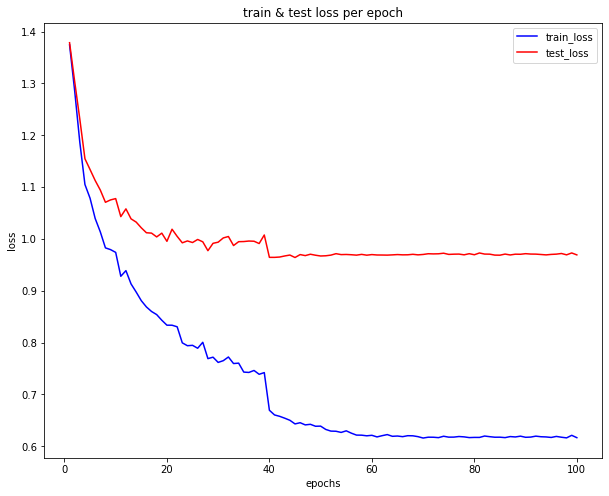

In [17]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

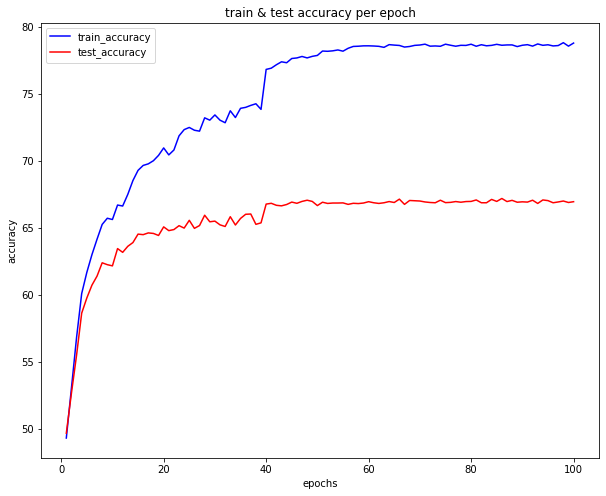

In [18]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [19]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 86
Train: accuracy: 78.6%, avg loss: 0.616718
Test: accuracy: 67.2%, avg loss: 0.970824


## 5.4 Model metrics

In [20]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.82      0.84      0.83      5000
  automobile       0.90      0.91      0.90      5000
        bird       0.74      0.64      0.69      5000
         cat       0.59      0.56      0.58      5000
        deer       0.72      0.77      0.74      5000
         dog       0.69      0.64      0.66      5000
        frog       0.82      0.86      0.84      5000
       horse       0.81      0.84      0.83      5000
        ship       0.87      0.92      0.89      5000
       truck       0.86      0.88      0.87      5000

    accuracy                           0.79     50000
   macro avg       0.78      0.79      0.78     50000
weighted avg       0.78      0.79      0.78     50000

Test:
              precision    recall  f1-score   support

    airplane       0.71      0.73      0.72      1000
  automobile       0.81      0.81      0.81      1000
        bird       0.60      0.51      0.55      1000
         ca

<AxesSubplot:>

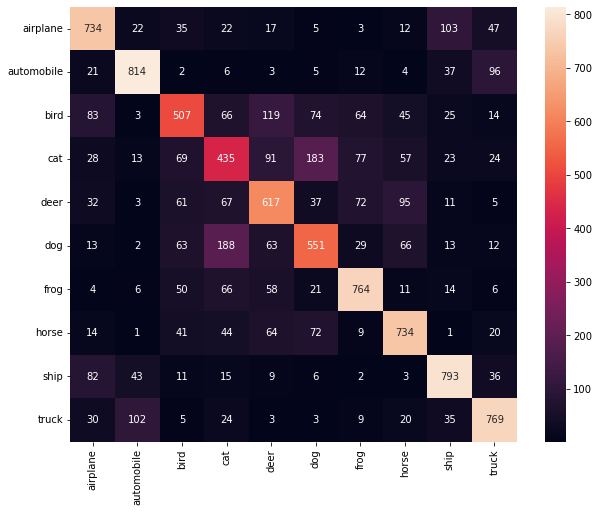

In [21]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [22]:
torch.save(best_model_state_dict, '../saved-model/cnn-weights.pth')